# Big Data Analysis using PySpark

COMPANY: CODTECH IT SOLUTIONS

NAME: YAKKALA LAHARI

INTERN ID: CT04DY2623

DOMAIN: DATA ANALYTICS

### **Import Libraries**

In [1]:
import sys
import tempfile
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, avg, count, hour, to_timestamp, desc, when, approx_count_distinct, sum as spark_sum
)
import matplotlib.pyplot as plt
import os
os.environ["HADOOP_HOME"] = "C:\\hadoop"
os.environ["hadoop.home.dir"] = "C:\\hadoop"

In [2]:
# Configuration

DATA_DIR = "/mnt/data/nyc_yellow_taxi"
os.makedirs(DATA_DIR, exist_ok=True)

PARQUET_URL = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet"
PARQUET_LOCAL = os.path.join(DATA_DIR, "yellow_tripdata_2023-01.parquet")

In [3]:
def download_if_missing(url, local_path):
    if os.path.exists(local_path):
        print(f"Dataset already present at: {local_path}")
        return local_path
    print(f"Downloading dataset to {local_path} ...")
    import requests
    with requests.get(url, stream=True, timeout=60) as r:
        r.raise_for_status()
        with open(local_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
    print("Download completed.")
    return local_path

In [4]:
def initialize_spark(app_name="BigData_PySpark_Analysis", master="local[*]", driver_memory="4g"):
    spark = (
        SparkSession.builder
        .appName(app_name)
        .master(master)
        .config("spark.driver.memory", driver_memory)
        .config("spark.sql.shuffle.partitions", "200")
        .getOrCreate()
    )
    print("Spark initialized:", spark.sparkContext.appName)
    return spark

In [5]:
def load_parquet(spark, path):
    print(f"Loading parquet from: {path}")
    df = spark.read.parquet(path)
    print("Schema:")
    df.printSchema()
    return df

## Data Preprocessing

In [6]:
def preprocess(df):
    if 'tpep_pickup_datetime' in df.columns and str(df.schema['tpep_pickup_datetime'].dataType).lower().startswith('string'):
        df = df.withColumn('tpep_pickup_datetime', to_timestamp(col('tpep_pickup_datetime')))
    df = df.dropna(subset=['tpep_pickup_datetime', 'trip_distance', 'fare_amount'])
    df = df.filter((col('trip_distance') >= 0) & (col('fare_amount') >= 0))
    return df

In [7]:
def perform_eda(df):
    print("Total records:")
    print(df.count())
    df = df.withColumn('pickup_hour', hour(col('tpep_pickup_datetime')))
    trips_by_hour = df.groupBy('pickup_hour').agg(count('*').alias('trip_count')).orderBy('pickup_hour')
    trips_by_hour.show(24, truncate=False)
    avg_fare = df.groupBy('passenger_count').agg(avg('fare_amount').alias('avg_fare'), count('*').alias('count')).orderBy('passenger_count')
    avg_fare.show()
    if 'PULocationID' in df.columns:
        top_pu = df.groupBy('PULocationID').agg(count('*').alias('trips')).orderBy(desc('trips')).limit(20)
        top_pu.show(20, truncate=False)
    return {'trips_by_hour': trips_by_hour, 'avg_fare': avg_fare, 'top_pu': top_pu if 'PULocationID' in df.columns else None, 'clean_df': df}

In [8]:
def analyze(df):
    df1 = df.filter(col('trip_distance') > 0).withColumn('fare_per_mile', col('fare_amount') / col('trip_distance'))
    fare_stats = df1.select('fare_per_mile').describe().toPandas()
    print("Fare per mile stats:\n", fare_stats)
    from pyspark.sql.functions import dayofweek
    dow_hour = df.withColumn('dow', dayofweek(col('tpep_pickup_datetime'))).groupBy('dow', 'pickup_hour').agg(count('*').alias('trips')).orderBy(desc('trips')).limit(20)
    dow_hour.show()
    summary = df1.groupBy('passenger_count').agg(count('*').alias('trips'), avg('fare_amount').alias('avg_fare'), avg('trip_distance').alias('avg_distance')).orderBy('passenger_count')
    return summary

## Visualization

In [9]:
def visualize(aggregates_dict):
    trips_by_hour_pdf = aggregates_dict['trips_by_hour'].toPandas()
    plt.figure(figsize=(10,5))
    plt.plot(trips_by_hour_pdf['pickup_hour'], trips_by_hour_pdf['trip_count'], marker='o')
    plt.title('Trips by Pickup Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Trip Count')
    plt.grid(True)
    plt.show()


In [10]:
def visualize(aggregates_dict):
    avg_fare_pdf = aggregates_dict['avg_fare'].toPandas()
    plt.figure(figsize=(8,4))
    plt.bar(avg_fare_pdf['passenger_count'].astype(str), avg_fare_pdf['avg_fare'])
    plt.title('Average Fare by Passenger Count')
    plt.xlabel('Passenger Count')
    plt.ylabel('Average Fare ($)')
    plt.show()

In [11]:
def save_results(df_summary, out_dir=os.path.join(DATA_DIR, 'results')):
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, 'passenger_summary.csv')
    print(f"Saving summary to {out_path}")
    df_summary.coalesce(1).write.mode('overwrite').option('header', True).csv(out_path)
    print("Saved.")

In [12]:
from pyspark.sql import SparkSession

def initialize_spark(app_name="BigDataAnalysis"):
    """
    Initialize and return a SparkSession.
    """
    spark = SparkSession.builder \
        .appName(app_name) \
        .config("spark.driver.memory", "4g") \
        .config("spark.executor.memory", "4g") \
        .getOrCreate()
    
    print("Spark session initialized successfully.")
    return spark


In [13]:
import os
import urllib.request

def download_if_missing(url, local_path):
    """
    Download a dataset file if it doesn't already exist locally.
    """
    if not os.path.exists(local_path):
        print(f"Downloading dataset from {url}")
        try:
            urllib.request.urlretrieve(url, local_path)
            print(f"Download completed: {local_path}")
        except Exception as e:
            raise RuntimeError(f"Failed to download dataset: {e}")
    else:
        print(f"Dataset already exists locally at: {local_path}")


Dataset already exists locally at: /mnt/data/nyc_yellow_taxi\yellow_tripdata_2023-01.parquet
Spark session initialized successfully.
Loading parquet from: /mnt/data/nyc_yellow_taxi\yellow_tripdata_2023-01.parquet
Schema:
root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- 

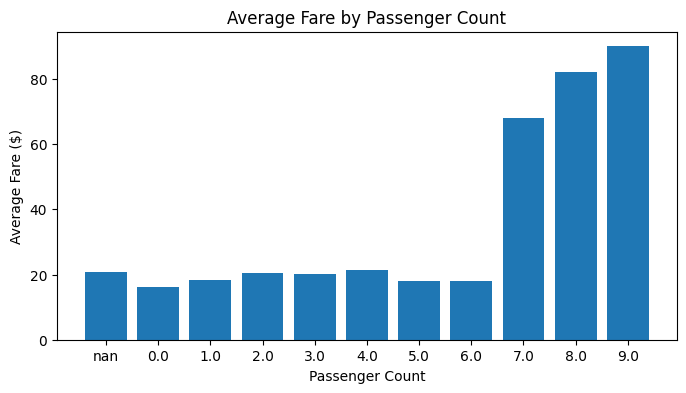

Saving summary to /mnt/data/nyc_yellow_taxi\results\passenger_summary.csv
Spark session stopped.


Py4JJavaError: An error occurred while calling o377.csv.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: Hadoop home directory C:\hadoop does not exist -see https://cwiki.apache.org/confluence/display/HADOOP2/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:789)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:298)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:314)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:1116)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:798)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:838)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:837)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:837)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:988)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:356)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:190)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.writeAndCommit(FileFormatWriter.scala:268)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeWrite(FileFormatWriter.scala:306)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:189)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:195)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:117)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:115)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:129)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:402)
	at org.apache.spark.sql.execution.adaptive.ResultQueryStageExec.$anonfun$doMaterialize$1(QueryStageExec.scala:325)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$4(SQLExecution.scala:322)
	at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:272)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$3(SQLExecution.scala:320)
	at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$2(SQLExecution.scala:316)
	at java.base/java.util.concurrent.CompletableFuture$AsyncSupply.run(CompletableFuture.java:1768)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at org.apache.spark.util.Utils$.getTryWithCallerStacktrace(Utils.scala:1439)
	at org.apache.spark.util.LazyTry.get(LazyTry.scala:58)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:131)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:192)
	at org.apache.spark.sql.classic.DataFrameWriter.runCommand(DataFrameWriter.scala:622)
	at org.apache.spark.sql.classic.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:273)
	at org.apache.spark.sql.classic.DataFrameWriter.saveInternal(DataFrameWriter.scala:241)
	at org.apache.spark.sql.classic.DataFrameWriter.save(DataFrameWriter.scala:118)
	at org.apache.spark.sql.DataFrameWriter.csv(DataFrameWriter.scala:426)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:578)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:1623)
	Suppressed: org.apache.spark.util.Utils$OriginalTryStackTraceException: Full stacktrace of original doTryWithCallerStacktrace caller
		at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:789)
		at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:298)
		at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:314)
		at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:1116)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:798)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:838)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:837)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:837)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
		at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:988)
		at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:356)
		at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:190)
		at org.apache.spark.sql.execution.datasources.FileFormatWriter$.writeAndCommit(FileFormatWriter.scala:268)
		at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeWrite(FileFormatWriter.scala:306)
		at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:189)
		at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:195)
		at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:117)
		at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:115)
		at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:129)
		at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:402)
		at org.apache.spark.sql.execution.adaptive.ResultQueryStageExec.$anonfun$doMaterialize$1(QueryStageExec.scala:325)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$4(SQLExecution.scala:322)
		at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:272)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$3(SQLExecution.scala:320)
		at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$2(SQLExecution.scala:316)
		at java.base/java.util.concurrent.CompletableFuture$AsyncSupply.run(CompletableFuture.java:1768)
		at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
		at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
		... 1 more
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: Hadoop home directory C:\hadoop does not exist -see https://cwiki.apache.org/confluence/display/HADOOP2/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:601)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:622)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:645)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:742)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:80)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1954)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1912)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1885)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:304)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$install$1(ShutdownHookManager.scala:194)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.scala:18)
	at scala.Option.fold(Option.scala:263)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:195)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:55)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:53)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:159)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala:63)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:250)
	at org.apache.spark.util.SparkFileUtils.createTempDir(SparkFileUtils.scala:103)
	at org.apache.spark.util.SparkFileUtils.createTempDir$(SparkFileUtils.scala:102)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:99)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:379)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:961)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:204)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:227)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:96)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1132)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1141)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: Hadoop home directory C:\hadoop does not exist
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:544)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:492)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:569)
	... 27 more


In [17]:
def main():
    try:
        download_if_missing(PARQUET_URL, PARQUET_LOCAL)
    except Exception as e:
        print(str(e))
    
    spark = initialize_spark()
    
    try:
        df = load_parquet(spark, PARQUET_LOCAL)
        df_clean = preprocess(df)
        aggregates = perform_eda(df_clean)
        summary = analyze(aggregates['clean_df'])
        summary.show()
        visualize(aggregates)
        save_results(summary)
    finally:
        spark.stop()
        print('Spark session stopped.')

if __name__ == '__main__':
    main()


# Thank You